# Descriptive stats for datasets and network localization

-------------------

Author: Brin Rosenthal (sbrosenthal@ucsd.edu)

-------------------

Updated 7/3/19 to remove extraneous code, add comments, and clarify

4/28/20: more cleanup





<a id='import'></a>
## Import packages

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

from IPython.display import display

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set_style('white')

import sys

% matplotlib inline

In [2]:
# need to have networkx version 1.11
nx.__version__

'1.11'

In [4]:
# import network localization methods

sys.path.append('netprop_zscore_code/')
import network_localization

#### Some gene symbols in the data were out of data (not consistent with PCnet) -- load mapping

In [5]:
map_old_new = pd.read_csv('../../data/ASD_EPI_CHD_HC_and_DNVs_symbol_gene_description.txt',sep='\t')
map_old_new.index=map_old_new['original_symbol']
map_old_new = map_old_new['symbol']
map_old_new.head()

original_symbol
A2M          A2M
A2ML1      A2ML1
AASS        AASS
ABCA1      ABCA1
ABCA13    ABCA13
Name: symbol, dtype: object

[TOC](#toc)

<a id='importData'></a>
# Load the data- including ASD and CHD high confidence genes, and DNV sets

ASD, CHD gene lists (suggested by Jeremy)

ASD genes come from table 4 in http://www.cell.com/neuron/fulltext/S0896-6273(15)00773-4 

In [6]:
# ------- ASD HC genes -------

ASD_HC = pd.read_csv('../../data/ASD_HC.txt',names=['HC_genes'])

ASD_HC = ASD_HC['HC_genes'].tolist()
len(ASD_HC)




65

In [6]:
# ------- High confidence CHD genes -------

# Load congenital heart defect recurring DNVs (from https://www.nature.com/articles/ng.3970)

CHD_seed_type='CHD_full' # can be 'CHD_withNDD', 'CHD_full', or 'CHD_only'


if CHD_seed_type=='CHD_full':
    # new HC genes:
    CHD_HC = pd.read_csv('../../data/CHD_HC_new.txt',names=['HC_genes'])
elif CHD_seed_type=='CHD_withNDD':
    CHD_HC = pd.read_csv('../../data/CHD_withNDD_HC_new.txt',names=['HC_genes'])
elif CHD_seed_type=='CHD_only':
    CHD_HC = pd.read_csv('../../data/CHD_only_HC_new.txt',names=['HC_genes'])

CHD_HC = CHD_HC['HC_genes'].tolist()
len(CHD_HC)

66

In [7]:
# Load all NDD DNVs (from CHD paper)
NDD_df = pd.read_excel('../../data/CHD_NDD_databases/homsy_database_S08.xlsx',skiprows=1)
ASD_DNV = NDD_df[NDD_df['Study']=='SSC'] # simons simplex data
print('\nnumber total ASD damaging DNVs')
print(len(ASD_DNV))
ASD_DNV_VC = ASD_DNV['Gene'].value_counts() # count recurrences
ASD_DNV = list(np.unique(ASD_DNV['Gene'].tolist()))
print('\nnumber unique ASD damaging DNVs:')
print(len(map_old_new.loc[ASD_DNV].dropna()))
ASD_DNV = map_old_new.loc[ASD_DNV].tolist()

print('\nnumber recurrent ASD damaging DNVs')
print(sum(ASD_DNV_VC>1)) # number recurrent ASD


number total ASD damaging DNVs
750

number unique ASD damaging DNVs:
663

number recurrent ASD damaging DNVs
63


In [8]:
# Load the new cohort (Supp table 9 from https://www.nature.com/articles/ng.3970)
CHD_new_df = pd.read_excel('../../data/CHD_databases_2017_paper/ng.3970-S3.xlsx',sheetname='S9',skiprows=1)
CHD_new_df.index=CHD_new_df['Blinded ID']

# apply the same filtering as for old data
CHD_new_df = CHD_new_df[(CHD_new_df['Variant_Class']!='syn')&(CHD_new_df['Variant_Class']!='mis')]

print('number total CHD damaging DNVs:')
print(len(CHD_new_df))

DNV_noNDD_full = CHD_new_df[CHD_new_df['NDD']=='No']
DNV_noNDD_full = DNV_noNDD_full['Gene'].unique().tolist()
print('\nnumber damaging CHD DNVs without NDD:')
print(len(DNV_noNDD_full))

DNV_withNDD_full = CHD_new_df[CHD_new_df['NDD']=='Yes']
DNV_withNDD_full = DNV_withNDD_full['Gene'].unique().tolist()
print('\nnumber damaging CHD DNVs with NDD:')
print(len(DNV_withNDD_full))

CHD_DNV = CHD_new_df['Gene'].unique().tolist()
CHD_DNV_VC = CHD_new_df['Gene'].value_counts()

print('\nnumber unique CHD damaging DNVs:')
print(len(CHD_DNV))


print('\nnumber recurrent CHD damaging DNVs ')
print(sum(CHD_DNV_VC>1)) # number recurrent CHD

/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


number total CHD damaging DNVs:
827

number damaging CHD DNVs without NDD:
309

number damaging CHD DNVs with NDD:
198

number unique CHD damaging DNVs:
705

number recurrent CHD damaging DNVs 
66


In [9]:
# Load control DNVs (from Database S3)
ctrl_DNV_df = pd.read_excel('../../data/CHD_NDD_databases/homsy_database_S03.xlsx',skiprows=1)

# exclude synonymouse and non-damaging missense
ctrl_DNV = ctrl_DNV_df[(ctrl_DNV_df['Variant Class']!='Synonymous')&(ctrl_DNV_df['Variant Class']!='Missense')]
ctrl_DNV_VC = ctrl_DNV['Gene'].value_counts()
print('number damaging control DNVs:')
print(len(ctrl_DNV))
#ctrl_DNV = ctrl_DNV_df
ctrl_DNV = list(np.unique(ctrl_DNV['Gene'].tolist()))
print('\nnumber unique damaging control DNVs:')
print(len(ctrl_DNV))

print('\nnumber recurrent damaging control DNVs:')
print(sum(ctrl_DNV_VC>1))


number damaging control DNVs:
201

number unique damaging control DNVs:
193

number recurrent damaging control DNVs:
7


## Define gene sets for use in rest of analysis

In [10]:
# pick out which gene sets to investigate
genes_ASD = ASD_HC
print(len(genes_ASD))
genes_CHD = CHD_HC
print(len(genes_CHD))

65
66


[TOC](#toc)

<a id='plotHCgenes'></a>
# Make figure 1: summary of HC genes in CHD and ASD  (showing low recurrence)



In [11]:
ASD_df = NDD_df[(NDD_df['Study']=='SSC')]
ASD_df.head()

,Study,CHR,POS,REF,ALT,Proband ID,Class,Class (2),Gene,Ensembl Gene ID,AA1,AA2,dbNSFP Meta-SVM Rankscore
1,SSC,1,1222518,C,A,11563.p1,nonsense,lof,SCNN1D,ENSG00000162572,NaN,NaN,NaN
3,SSC,1,3519049,AC,A,14075.p1,frameshift,lof,MEGF6,ENSG00000162591,NaN,NaN,NaN
4,SSC,1,11205057,T,C,11104.p1,missense,D-mis,MTOR,ENSG00000198793,M,V,0.83852
5,SSC,1,12175787,G,A,12340.p1,splice,lof,TNFRSF8,ENSG00000120949,NaN,NaN,NaN
6,SSC,1,12428630,T,C,13930.p1,missense,D-mis,VPS13D,ENSG00000048707,I,T,0.84048


In [12]:
CHD_DNV_df = CHD_new_df
CHD_DNV_df.head()

,Blinded ID,Cardiac Category,EM,NDD,CHROM,POS,REF,ALT,Ensemble_GENEID,Gene,Variant_Class,AA change,RadialSVM_score,RadialSVM_pred,ExAC_Overall,HHE Rank,pLI score
Blinded ID,,,,,,,,,,,,,,,,,
1-07417,1-07417,CTD,Yes,Unknown,5,132097207,C,G,ENSG00000164402,SEPT8,misD,p.R302P,0.657,D,.,86.369549,9.542857e-01
1-12717,1-12717,CTD,Yes,Yes,10,101578577,C,T,ENSG00000023839,ABCC2,misD,p.R768W,1.065,D,7.42e-05,16.124654,3.363414e-29
1-06692,1-06692,CTD,No,Unknown,17,48762187,C,T,ENSG00000108846,ABCC3,non,p.Q1411X,.,.,.,32.809230,2.616130e-14
1-06555,1-06555,other,No,No,1,94943860,A,G,ENSG00000117528,ABCD3,misD,p.I225V,1.123,D,3.34e-05,77.665290,9.996956e-01
1-07919,1-07919,LVO,Yes,No,4,146025629,G,A,ENSG00000164163,ABCE1,misD,p.R22Q,0.113,D,1.72e-05,82.195577,9.999826e-01


In [13]:
# rename CHD_DNV_df columns for merge with ASD_df

cols_keep = ['Blinded ID', 'CHROM', 'POS','REF','ALT','Gene','Ensemble_GENEID','Variant_Class','AA change']

new_columns = ['Proband ID', 'CHR', 'POS', 'REF', 'ALT', 'Gene',
       'Ensembl Gene ID', 'Class', 'AA Change']
CHD_DNV_for_merge = CHD_DNV_df.copy(deep=True)
CHD_DNV_for_merge = CHD_DNV_for_merge[cols_keep]

# get rid of non-damaging missense and synonymous 
CHD_DNV_for_merge.columns = new_columns
CHD_DNV_for_merge = CHD_DNV_for_merge[(CHD_DNV_for_merge['Class']!='Missense') & (CHD_DNV_for_merge['Class']!='Synonymous')]
CHD_DNV_for_merge['Study']='CHD'
CHD_DNV_for_merge.head()

,Proband ID,CHR,POS,REF,ALT,Gene,Ensembl Gene ID,Class,AA Change,Study
Blinded ID,,,,,,,,,,
1-07417,1-07417,5,132097207,C,G,SEPT8,ENSG00000164402,misD,p.R302P,CHD
1-12717,1-12717,10,101578577,C,T,ABCC2,ENSG00000023839,misD,p.R768W,CHD
1-06692,1-06692,17,48762187,C,T,ABCC3,ENSG00000108846,non,p.Q1411X,CHD
1-06555,1-06555,1,94943860,A,G,ABCD3,ENSG00000117528,misD,p.I225V,CHD
1-07919,1-07919,4,146025629,G,A,ABCE1,ENSG00000164163,misD,p.R22Q,CHD


In [14]:
columns_to_keep = ['Study','Proband ID', 'CHR', 'POS', 'REF', 'ALT', 'Gene',
       'Ensembl Gene ID', 'Class']
ASD_CHD_df = ASD_df[columns_to_keep].append(CHD_DNV_for_merge[columns_to_keep])
ASD_CHD_df.head()


,Study,Proband ID,CHR,POS,REF,ALT,Gene,Ensembl Gene ID,Class
1,SSC,11563.p1,1,1222518,C,A,SCNN1D,ENSG00000162572,nonsense
3,SSC,14075.p1,1,3519049,AC,A,MEGF6,ENSG00000162591,frameshift
4,SSC,11104.p1,1,11205057,T,C,MTOR,ENSG00000198793,missense
5,SSC,12340.p1,1,12175787,G,A,TNFRSF8,ENSG00000120949,splice
6,SSC,13930.p1,1,12428630,T,C,VPS13D,ENSG00000048707,missense


In [15]:
ASD_CHD_df['Study'].value_counts()

CHD    827
SSC    750
Name: Study, dtype: int64

In [16]:
# index by gene name, subset by HC genes, sort by relevant fields
ASD_CHD_df.index=ASD_CHD_df['Gene']
# add a column for gene value count
gene_VC = ASD_CHD_df['Gene'].value_counts()
ASD_CHD_df['value_count']=0
ASD_CHD_df['value_count'].loc[gene_VC.index]=gene_VC

# add a column for HC gene
ASD_CHD_df['is_HC_gene']=0
ASD_CHD_df['is_HC_gene'].loc[np.intersect1d(ASD_CHD_df['Gene'].tolist(),ASD_HC)]=1
ASD_CHD_df['is_HC_gene'].loc[np.intersect1d(ASD_CHD_df['Gene'].tolist(),CHD_HC)]=1

# add a column for study_int (integer representing study SSC:0, CHD:1)
ASD_CHD_df['study_int']=0
ASD_CHD_df.index=ASD_CHD_df['Study']
ASD_CHD_df['study_int'].loc['SSC']=0
ASD_CHD_df['study_int'].loc['CHD']=1
ASD_CHD_df.index=ASD_CHD_df['Gene']

print(len(ASD_CHD_df))

# sort dataframe by study_int, value_count (number of patients with variant in gene), and class (type of variant)
AC_sorted = ASD_CHD_df.sort_values(['study_int','value_count','Class'],ascending=False)
AC_sorted.head()

1577


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Study,Proband ID,CHR,POS,REF,ALT,Gene,Ensembl Gene ID,Class,value_count,is_HC_gene,study_int
Gene,,,,,,,,,,,,
KMT2D,CHD,1-07473,12,49427848,A,T,KMT2D,ENSG00000167548,splice,17,1,1
KMT2D,CHD,1-10799,12,49424741,G,A,KMT2D,ENSG00000167548,non,17,1,1
KMT2D,CHD,1-12480,12,49448767,G,C,KMT2D,ENSG00000167548,non,17,1,1
KMT2D,CHD,1-05572,12,49425896,G,A,KMT2D,ENSG00000167548,non,17,1,1
KMT2D,CHD,1-07570,12,49437701,G,A,KMT2D,ENSG00000167548,non,17,1,1


In [17]:
# map from variant class to integer
class_VC = AC_sorted['Class'].value_counts()
class_VC
class_to_int = {'missense':1,'frameshift':2,'D-Missense':1,'misD':1,'nonsense':3,'splice':4,'Nonsense':3,
                'Splice site':4,'non':3,
               'startloss':5,'Start lost':5,'Missense/Missense':1,'Stop lost':5,'stoploss':5}
class_to_int

{'D-Missense': 1,
 'Missense/Missense': 1,
 'Nonsense': 3,
 'Splice site': 4,
 'Start lost': 5,
 'Stop lost': 5,
 'frameshift': 2,
 'misD': 1,
 'missense': 1,
 'non': 3,
 'nonsense': 3,
 'splice': 4,
 'startloss': 5,
 'stoploss': 5}

In [18]:
# ASD DNVs
ASD_DNV_df = NDD_df[NDD_df['Study']=='SSC'].copy(deep=True)
ASD_DNV_df.head()


,Study,CHR,POS,REF,ALT,Proband ID,Class,Class (2),Gene,Ensembl Gene ID,AA1,AA2,dbNSFP Meta-SVM Rankscore
1,SSC,1,1222518,C,A,11563.p1,nonsense,lof,SCNN1D,ENSG00000162572,NaN,NaN,NaN
3,SSC,1,3519049,AC,A,14075.p1,frameshift,lof,MEGF6,ENSG00000162591,NaN,NaN,NaN
4,SSC,1,11205057,T,C,11104.p1,missense,D-mis,MTOR,ENSG00000198793,M,V,0.83852
5,SSC,1,12175787,G,A,12340.p1,splice,lof,TNFRSF8,ENSG00000120949,NaN,NaN,NaN
6,SSC,1,12428630,T,C,13930.p1,missense,D-mis,VPS13D,ENSG00000048707,I,T,0.84048


In [19]:
np.setdiff1d(ASD_HC+CHD_HC,AC_sorted['Gene'].tolist())

array(['APH1A', 'ERBIN', 'GABRB3', 'KMT5B', 'NLGN3', 'RANBP17', 'SHANK3',
       'ZNF559'], dtype='|S8')

In [20]:
# make a gene by patient matrix
genes_HC = np.intersect1d(ASD_HC+CHD_HC,AC_sorted['Gene'].tolist()) # make sure they are in the DF
gene_VC_HC = gene_VC.loc[genes_HC].sort_values(ascending=False)

genes_of_interest = gene_VC_HC.index.tolist()

# initialize
gene_by_patient = pd.DataFrame(np.nan*np.zeros((len(genes_of_interest),len(AC_sorted))),index=genes_of_interest)
gene_by_patient.columns=AC_sorted['Proband ID']

for g in genes_of_interest:
    patients_with_g = AC_sorted.loc[g]['Proband ID']
    if type(patients_with_g)!=unicode:
        patients_with_g = patients_with_g.tolist()
    else:
        patients_with_g = [patients_with_g]
    AC_gene_temp = AC_sorted.loc[g].copy(deep=True)
    if type(AC_gene_temp) == pd.core.series.Series: # deal with case of only one gene match 
        AC_gene_temp = pd.DataFrame(AC_gene_temp).T
        
    AC_gene_temp.index=AC_gene_temp['Proband ID']
    for p in patients_with_g:
        
        gene_by_patient.loc[g][p]=class_to_int[AC_gene_temp['Class'].loc[p]]

# sort the df by ASD/CHD/EPI high confidence membership
gbp_ASD = gene_by_patient.copy(deep=True).loc[ASD_HC].dropna(how='all')
gbp_ASD = (gbp_ASD>0).sum(axis=1).sort_values(ascending=False)


gbp_CHD = gene_by_patient.copy(deep=True).loc[CHD_HC].dropna(how='all')
gbp_CHD = (gbp_CHD>0).sum(axis=1).sort_values(ascending=False)
gbp_CHD.head()

# now reorder
new_index = pd.Series(gbp_CHD.index.tolist()+gbp_ASD.index.tolist())
new_index = new_index.drop_duplicates()

gene_by_patient = gene_by_patient.loc[new_index.tolist()]

gene_by_patient.head()


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


Proband ID,1-07473,1-10799,1-12480,1-05572,1-07570,1-08173,GT04008173,1-03948,1-00780,1-08730,...,13054.p1,13691.p1,14310.p1,14292.p1,13359.p1,13256.p1,13861.p1,14597.p1,11609.p1,13739.p1
KMT2D,4.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHD7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PTPN11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KDM5B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NSD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
gene_by_patient = gene_by_patient.dropna(axis=1,how='all') # drop patients with no HC DNVs
gene_by_patient = gene_by_patient.T
gene_by_patient = gene_by_patient[~gene_by_patient.index.duplicated(keep='first')]
gene_by_patient = gene_by_patient.T

# note: not all ASD high confidence genes are in this dataset- they were defined using a different dataset
print('number of HC genes:')
print(len(gene_by_patient))
print('\nnumber of patients with at least one HC gene:')
print(len(gene_by_patient.columns))



number of HC genes:
118

number of patients with at least one HC gene:
307


In [22]:
# find the total numbers of ASD and CHD patients explained by the high confidence genes
ASD_count = (gene_by_patient[list(np.intersect1d(ASD_DNV_df['Proband ID'].tolist(),gene_by_patient.columns.tolist()))]>0).sum(axis=1)
print(sum(ASD_count))

CHD_count = (gene_by_patient[list(np.intersect1d(CHD_DNV_df.index.tolist(),gene_by_patient.columns.tolist()))]>0).sum(axis=1)
print(sum(CHD_count))

120
198


([], <a list of 0 Text xticklabel objects>)

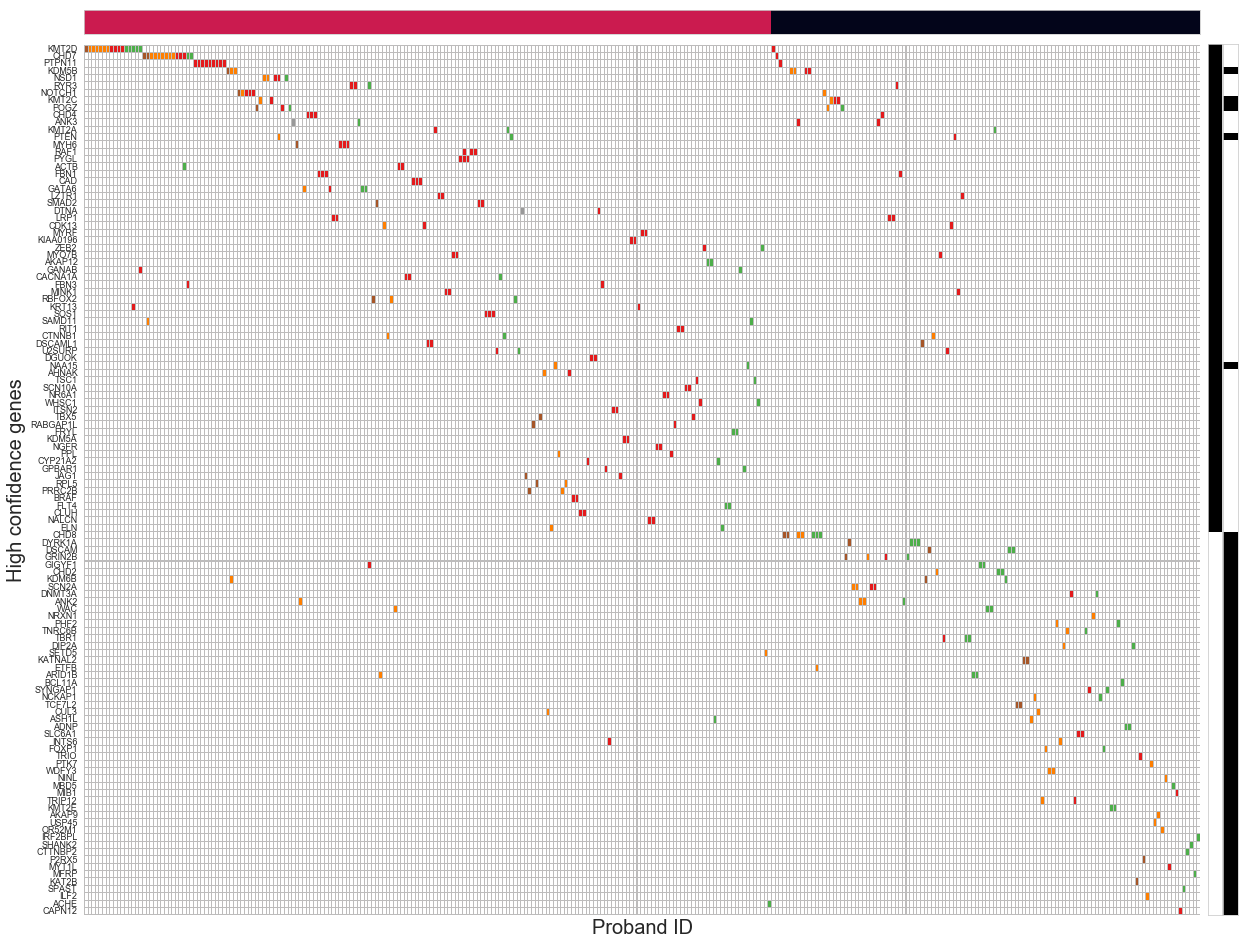

In [23]:
# now plot the figure

sns.set_style('whitegrid')

plt.figure(figsize=(20,16))
h = sns.heatmap(gene_by_patient,xticklabels=False,cbar=False,cmap='Set1',linewidths=.01,linecolor='#BDBCBC')

plt.sca(h.axes)
plt.xlabel('Proband ID',fontsize=20)
plt.ylabel('High confidence genes',fontsize=20)

yticklabels = [g for g in gene_by_patient.index.tolist()]

tmp = plt.yticks(np.arange(len(gene_by_patient))+.4,yticklabels,fontsize=9)

# add bars above fig
AC_sorted.index = AC_sorted['Gene']
AC_temp = AC_sorted.loc[genes_of_interest].copy(deep=True)
AC_temp.index=AC_temp['Proband ID']
temp = AC_temp['study_int'].loc[gene_by_patient.columns]
temp = temp[~temp.index.duplicated(keep='first')]
temp = np.array(temp.tolist())
temp = temp[np.newaxis,:]
AC_sorted.index = AC_sorted['Gene']

h.figure.add_axes([.125,.89,.775,.02]).pcolor(temp,vmin=0,vmax=2)
plt.xlim(0,len(gene_by_patient.columns))
plt.yticks([],'')
plt.xticks([],'')

# add a bar next to fig, for which HC gene set they belong to
#ASD_HC_row
temp_row = pd.Series(np.zeros(len(gene_by_patient)),index=gene_by_patient.index.tolist())
temp_row.loc[np.intersect1d(temp_row.index,ASD_HC)]=1

temp_row = np.array(temp_row.tolist())
temp_row = temp_row[::-1,np.newaxis]
h.figure.add_axes([.916,.125,.01,.756]).pcolor(temp_row,cmap='Greys')
plt.ylim(0,len(gene_by_patient))
plt.yticks([],'')
plt.xticks([],'')

#CHD_HC_row
temp_row = pd.Series(np.zeros(len(gene_by_patient)),index=gene_by_patient.index.tolist())
temp_row.loc[np.intersect1d(temp_row.index,CHD_HC)]=1

temp_row = np.array(temp_row.tolist())
temp_row = temp_row[::-1,np.newaxis]
h.figure.add_axes([.905,.125,.01,.756]).pcolor(temp_row,cmap='Greys',)
plt.ylim(0,len(gene_by_patient))
plt.yticks([],'')
plt.xticks([],'')

# plt.savefig('../../manuscript/figures_1911/ASD_CHD_HC_by_mut_type.png',dpi=300,bbox_inches='tight')


# Bar chart- how many DNVs within established disease genes compared to outside?

In [24]:
print(len(ASD_df))
display(ASD_df['Class (2)'].value_counts())
ASD_df.head()

750


lof      391
D-mis    359
Name: Class (2), dtype: int64

,Study,CHR,POS,REF,ALT,Proband ID,Class,Class (2),Gene,Ensembl Gene ID,AA1,AA2,dbNSFP Meta-SVM Rankscore
1,SSC,1,1222518,C,A,11563.p1,nonsense,lof,SCNN1D,ENSG00000162572,NaN,NaN,NaN
3,SSC,1,3519049,AC,A,14075.p1,frameshift,lof,MEGF6,ENSG00000162591,NaN,NaN,NaN
4,SSC,1,11205057,T,C,11104.p1,missense,D-mis,MTOR,ENSG00000198793,M,V,0.83852
5,SSC,1,12175787,G,A,12340.p1,splice,lof,TNFRSF8,ENSG00000120949,NaN,NaN,NaN
6,SSC,1,12428630,T,C,13930.p1,missense,D-mis,VPS13D,ENSG00000048707,I,T,0.84048


In [25]:
display(CHD_DNV_for_merge['Class'].value_counts())
print(len(CHD_DNV_for_merge))
display(CHD_DNV_for_merge['Gene'].value_counts().head())
CHD_DNV_for_merge.head()

misD          453
frameshift    172
non           142
splice         51
startloss       5
stoploss        4
Name: Class, dtype: int64

827


KMT2D     16
CHD7      14
PTPN11     9
NSD1       5
NOTCH1     5
Name: Gene, dtype: int64

,Proband ID,CHR,POS,REF,ALT,Gene,Ensembl Gene ID,Class,AA Change,Study
Blinded ID,,,,,,,,,,
1-07417,1-07417,5,132097207,C,G,SEPT8,ENSG00000164402,misD,p.R302P,CHD
1-12717,1-12717,10,101578577,C,T,ABCC2,ENSG00000023839,misD,p.R768W,CHD
1-06692,1-06692,17,48762187,C,T,ABCC3,ENSG00000108846,non,p.Q1411X,CHD
1-06555,1-06555,1,94943860,A,G,ABCD3,ENSG00000117528,misD,p.I225V,CHD
1-07919,1-07919,4,146025629,G,A,ABCE1,ENSG00000164163,misD,p.R22Q,CHD


In [26]:
num_CHD_DNV_in_HC = sum(CHD_DNV_for_merge['Gene'].isin(ASD_HC+CHD_HC))
print(num_CHD_DNV_in_HC)
num_CHD_DNV_not_HC = sum(~CHD_DNV_for_merge['Gene'].isin(ASD_HC+CHD_HC))
print(num_CHD_DNV_not_HC)
num_CHD_no_DNV = 2645-(num_CHD_DNV_in_HC+num_CHD_DNV_not_HC)
print(num_CHD_no_DNV)

num_ASD_DNV_in_HC = sum(ASD_df['Gene'].isin(ASD_HC+CHD_HC))
print(num_ASD_DNV_in_HC)
num_ASD_DNV_not_HC = sum(~ASD_df['Gene'].isin(ASD_HC+CHD_HC))
print(num_ASD_DNV_not_HC)

num_ASD_no_DNV = 2759-(num_ASD_DNV_in_HC+num_ASD_DNV_not_HC)
print(num_ASD_no_DNV)

198
629
1818
120
630
2009


In [27]:
len(CHD_DNV_for_merge)

827

In [31]:
num_CHD_DNV_in_HC+num_CHD_DNV_not_HC

827

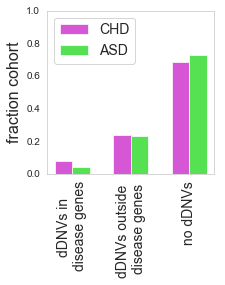

In [28]:
# add a bar showing the number of patients without damaging DNVs

sns.set_style('whitegrid',{'axes.grid':False})
plt.figure(figsize=(3,3))
plt.bar([-.15,.85,1.85],np.divide([num_CHD_DNV_in_HC,num_CHD_DNV_not_HC,num_CHD_no_DNV],2645.0),width=.3,color='#C410C4',alpha=.7,
       label='CHD')

plt.bar([.15,1.15,2.15],np.divide([num_ASD_DNV_in_HC,num_ASD_DNV_not_HC,num_ASD_no_DNV],2759.0),width=.3,color='#0ED50A',alpha=.7,
       label='ASD')
plt.ylim([0,1])
plt.xticks([0,1,2],['dDNVs in \ndisease genes', 'dDNVs outside \ndisease genes','no dDNVs'],fontsize=14,rotation='vertical')
plt.ylabel('fraction cohort',fontsize=16)
plt.legend(loc='upper left',fontsize=14)
# plt.savefig('../../manuscript/figures_1911/Figure1/DNVs_in_out_disease_genes.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Figure1/DNVs_in_out_disease_genes.svg',dpi=300,bbox_inches='tight')

In [29]:
num_ASD_DNV_in_HC+num_ASD_DNV_not_HC+num_ASD_no_DNV

2759

[TOC](#toc)

<a id='localization'></a>

# Select focal interactome, calculate network localization of DNVs

In [30]:
# load the pre-computed interactome
# PCnet downloaded from ndex and parsed to networkx format 
# https://ndexbio.org/#/network/f93f402c-86d4-11e7-a10d-0ac135e8bacf
Gint = nx.read_gpickle('/Users/brinrosenthal/Documents/CCBB_tickets_data/PCnet/G_PCnet.gpickle')
int_name = 'PCnet'

In [31]:
print(len(Gint.nodes()))
print(len(Gint.edges()))

19781
2724724


### How much overlap is there between disease genes and selected interactome?




In [32]:
print(len(np.intersect1d(list(ASD_HC),Gint.nodes())))
print(len(ASD_HC))


print(len(np.intersect1d(list(CHD_HC),Gint.nodes())))
print(len(CHD_HC))

65
65
66
66


[TOC](#toc)

<a id='disease_localization'></a>

# How localized are the individual diseases?

Two localization methods implemented here:

1.  Largest connected component (following Menche et al)
2.  Number shared edges in gene set (similar to method on STRING-DB)


## ASD localization

In [67]:
# ----- distributions for non-sampled case -----
# set numreps to 5000 for full run
num_reps=1000
ASD_numedges_list, ASD_numedges_rand, ASD_LCC_list, ASD_LCC_size_rand = network_localization.localization(Gint,
                                                                     focal_genes = ASD_DNV,
                                                                     num_reps = num_reps, 
                                                                     sample_frac = 1.0, 
                                                                     method = 'both', 
                                                                     plot = False,print_counter=True)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975


0.006164045119139927


Text(0.5,1,'permutation p = 0.006164045119139927')

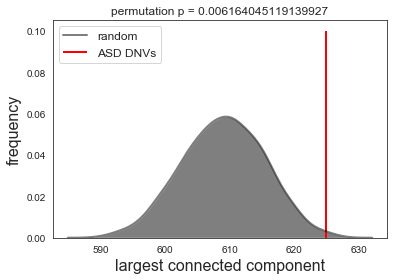

In [68]:
# plot distributions for non-sampled case
sns.set_style('white')
plt.vlines(np.mean(ASD_LCC_list),ymin=0,ymax=0.1,color='r',lw=2,label='ASD DNVs')
sns.kdeplot(ASD_LCC_size_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('largest connected component',fontsize=16)

# print the z-score and fdr
ASD_LCC_z = (np.mean(ASD_LCC_list)-np.mean(ASD_LCC_size_rand))/np.std(ASD_LCC_size_rand)

from scipy.special import ndtr
print(1-ndtr(ASD_LCC_z))

plt.title('permutation p = '+str(1-ndtr(ASD_LCC_z)))

# plt.savefig('../../manuscript/figures_18_12/supplement/ASD_LCC_'+int_name+'_no_bootstrap'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

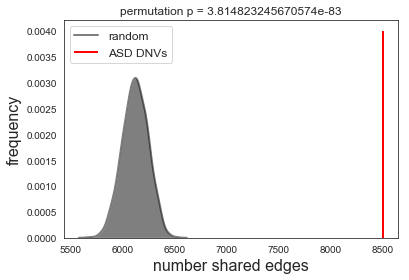

In [77]:
# plot distributions for non-sampled case
sns.set_style('white')
plt.vlines(np.mean(ASD_numedges_list),ymin=0,ymax=0.004,color='r',lw=2,label='ASD DNVs')
sns.kdeplot(ASD_numedges_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('number shared edges',fontsize=16)

# print the z-score and fdr
ASD_NE_z = (np.mean(ASD_numedges_list)-np.mean(ASD_numedges_rand))/np.std(ASD_numedges_rand)

from scipy.stats import norm
norm.sf(abs(ASD_NE_z))

plt.title('permutation p = '+str(norm.sf(abs(ASD_NE_z))))

# plt.savefig('../../manuscript/figures_18_12/supplement/ASD_numedges_'+int_name+'_no_bootstrap'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')
plt.savefig('../../manuscript/figures_1911/Supplement/ASD_DNV_numedges_'+int_name+'_no_bootstrap'+str(num_reps)+'.png',dpi=300,bbox_inches='tight')

## CHD localization

In [70]:
# ---- non-sampled case ----
# set numreps to 5000 for full run

num_reps=1000
CHD_numedges_list, CHD_numedges_rand, CHD_LCC_list, CHD_LCC_size_rand = network_localization.localization(Gint,
                                                                     focal_genes = CHD_DNV,
                                                                     num_reps = num_reps, 
                                                                     sample_frac = 1.0, 
                                                                     method = 'both', 
                                                                     plot = False,print_counter=True)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975


1.8983657447124713e-06


Text(0.5,1,u'permutation p = 1.8983657447124713e-06')

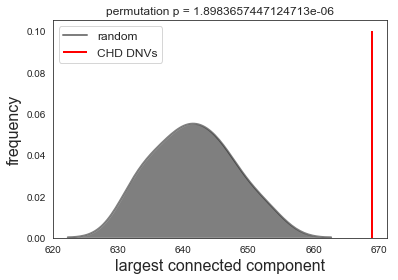

In [37]:
# plot distributions for non-sampled case
sns.set_style('white')
plt.vlines(np.mean(CHD_LCC_list),ymin=0,ymax=0.1,color='r',lw=2,label='CHD DNVs')
sns.kdeplot(CHD_LCC_size_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('largest connected component',fontsize=16)

# print the z-score and fdr
CHD_LCC_z = (np.mean(CHD_LCC_list)-np.mean(CHD_LCC_size_rand))/np.std(CHD_LCC_size_rand)

from scipy.special import ndtr
print(1-ndtr(CHD_LCC_z))

plt.title('permutation p = '+str(1-ndtr(CHD_LCC_z)))

# plt.savefig('../../manuscript/figures_18_02/supplement/CHD_LCC_'+int_name+'_no_bootstrap'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

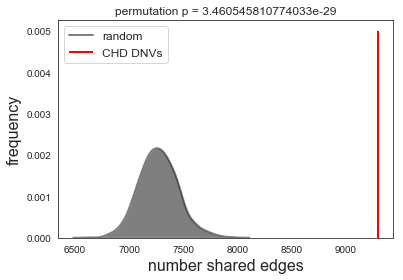

In [78]:
# plot distributions for non-sampled case
sns.set_style('white')
plt.vlines(np.mean(CHD_numedges_list),ymin=0,ymax=0.005,color='r',lw=2,label='CHD DNVs')
sns.kdeplot(CHD_numedges_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('number shared edges',fontsize=16)

# print the z-score and fdr
CHD_numedges_z = (np.mean(CHD_numedges_list)-np.mean(CHD_numedges_rand))/np.std(CHD_numedges_rand)

from scipy.stats import norm
norm.sf(abs(CHD_numedges_z))

plt.title('permutation p = '+str(norm.sf(abs(CHD_numedges_z))))

# plt.savefig('../../manuscript/figures_18_02/supplement/CHD_numedges_'+int_name+'_no_bootstrap'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')
plt.savefig('../../manuscript/figures_1911/Supplement/CHD_DNV_numedges_'+int_name+'_no_bootstrap'+str(num_reps)+'.png',dpi=300,bbox_inches='tight')

## Control cohort localization

In [48]:
len(ctrl_DNV)

193

In [53]:
# set numreps to 5000 for full run

num_reps=1000
CTRL_numedges_list, CTRL_numedges_rand, CTRL_LCC_list, CTRL_LCC_size_rand = network_localization.localization(Gint,
                                                                     focal_genes = ctrl_DNV,
                                                                     num_reps = num_reps, 
                                                                     sample_frac = 1.0, 
                                                                     method = 'both', 
                                                                     plot = False,print_counter=True)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975


0.04360502760126139


Text(0.5,1,'permutation p = 0.04360502760126139')

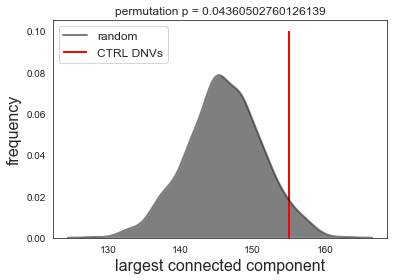

In [54]:
# plot distributions for non-sampled case
sns.set_style('white')
plt.vlines(np.mean(CTRL_LCC_list),ymin=0,ymax=0.1,color='r',lw=2,label='CTRL DNVs')
sns.kdeplot(CTRL_LCC_size_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('largest connected component',fontsize=16)

# print the z-score and fdr
CTRL_LCC_z = (np.mean(CTRL_LCC_list)-np.mean(CTRL_LCC_size_rand))/np.std(CTRL_LCC_size_rand)

from scipy.special import ndtr
print(1-ndtr(CTRL_LCC_z))

plt.title('permutation p = '+str(1-ndtr(CTRL_LCC_z)))

# plt.savefig('../../manuscript/figures_18_12/supplement/CTRL_LCC_'+int_name+'_no_bootstrap'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Supplement/CTRL_LCC_'+int_name+'_no_bootstrap'+str(num_reps)+'.png',dpi=300,bbox_inches='tight')

0.1998960084531256


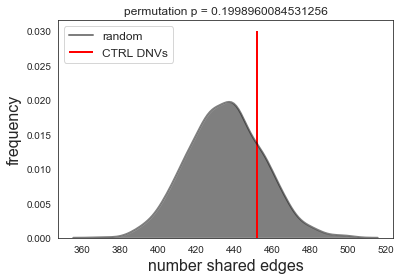

In [58]:
# plot distributions for non-sampled case
sns.set_style('white')
plt.vlines(np.mean(CTRL_numedges_list),ymin=0,ymax=0.03,color='r',lw=2,label='CTRL DNVs')
sns.kdeplot(CTRL_numedges_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('number shared edges',fontsize=16)

# print the z-score and fdr
CTRL_numedges_z = (np.mean(CTRL_numedges_list)-np.mean(CTRL_numedges_rand))/np.std(CTRL_numedges_rand)

from scipy.special import ndtr
print(1-ndtr(CTRL_numedges_z))

plt.title('permutation p = '+str(1-ndtr(CTRL_numedges_z)))

# plt.savefig('../../manuscript/figures_18_12/supplement/CTRL_numedges_'+int_name+'_no_bootstrap'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Supplement/CTRL_numedges_'+int_name+'_no_bootstrap'+str(num_reps)+'.png',dpi=300,bbox_inches='tight')

[TOC](#toc)